# <center> Classification </center>

In [1]:
# prevent SSL: CERTIFICATE_VERIFY_FAILED
# https://stackoverflow.com/questions/27835619/urllib-and-ssl-certificate-verify-failed-error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


## <center> 1. MNIST </center>

In [2]:
from sklearn.datasets import fetch_openml
import warnings

# ignore warning about future deprecation of default solver
warnings.simplefilter(action='ignore', category=FutureWarning)

# download MNIST dataset into directory 'data' on relative path
mnist = fetch_openml('mnist_784', version=1, data_home='data', as_frame=False)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# view data and target shape
X, y = mnist["data"], mnist["target"]
print(X.shape)  # 70,000 images, each image has 784 features
print(y.shape)  # 70,000 labels


(70000, 784)
(70000,)


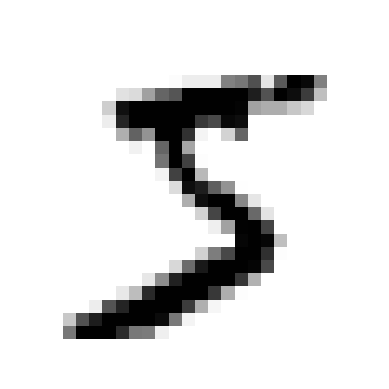

5


In [4]:
# view one digit from the dataset
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

# view the label
print(y[0])


In [5]:
# convert label from string to integer
import numpy as np
y = y.astype(np.uint8)


In [6]:
# separate training set and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


## <center> 2. Training a Binary Classifier </center>
Distinguishing between two classes, 5 and not-5.

In [7]:
# train a binary classifier to detect one digit
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)


In [8]:
# use Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# detect images of the number 5
sgd_clf.predict([some_digit])


array([ True])

## <center> 3. Performance Measures </center>

### <center> 3-1. Measuring Accuracy Using Cross-Validation </center>

In [9]:
# manually implement cross-validation for greater control
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# split training set into 3 folds
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# iterate through each fold
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # clone the classifier
    clone_clf = clone(sgd_clf)

    # get training and test sets
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    # train the clone classifier
    clone_clf.fit(X_train_folds, y_train_folds)

    # predict the test set
    y_pred = clone_clf.predict(X_test_fold)

    # calculate and print the accuracy
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


In [10]:
# use cross_val_score() to evaluate SGDClassifier model
from sklearn.model_selection import cross_val_score

# 3-fold cross-validation
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [11]:
# use a dumb classifier that classifies every single image in the "not-5" class
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        # return an array of 0s with the same length as X
        return np.zeros((len(X), 1), dtype=bool)


# 3-fold cross-validation
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

### <center> 3-2 Confusion Matrix </center>

In [12]:
from sklearn.model_selection import cross_val_predict

# return the predictions made on each test fold
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [13]:
from sklearn.metrics import confusion_matrix

# evaluate the confusion matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]])

In [14]:
# example of a perfect classifier
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)


array([[54579,     0],
       [    0,  5421]])

### <center> 3-3 Precision and Recall </center>

In [15]:
from sklearn.metrics import precision_score, recall_score

# calculate precision and recall
print(precision_score(y_train_5, y_train_pred))  # == 4096 / (4096 + 1522)
print(recall_score(y_train_5, y_train_pred))  # == 4096 / (4096 + 1325)


0.8370879772350012
0.6511713705958311


In [16]:
from sklearn.metrics import f1_score

# calculate F1 score
print(f1_score(y_train_5, y_train_pred))


0.7325171197343846


### <center> 3-4 Precision/Recall Tradeoff </center>

In [17]:
# get the decision score for each instance
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

# set a threshold to make predictions based on the decision score
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

# raise the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)


[2164.22030239]
[ True]
[False]


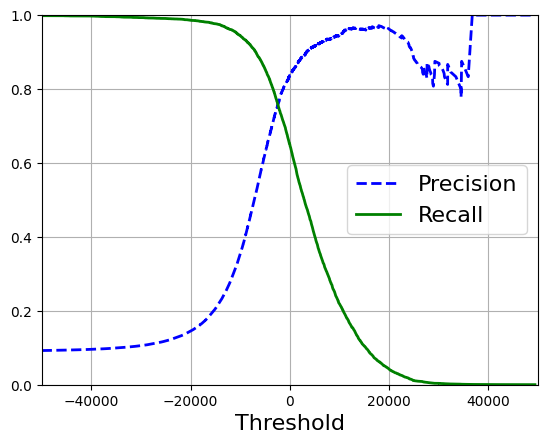

In [18]:
from sklearn.metrics import precision_recall_curve

# get the scores of all instances in the training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

# compute precision and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# plot precision and recall as functions of the threshold value


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--",
             label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


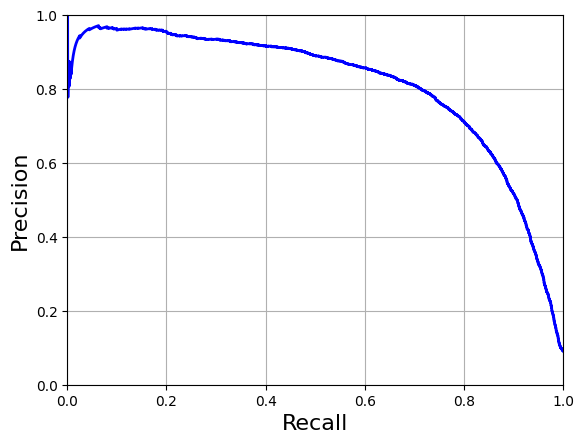

In [19]:
# plot precision directly against recall
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()


In [20]:
# select a threshold with a precision of 90%
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# make predictions using the new threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)

# check the precision and recall
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))


0.9000345901072293
0.4799852425751706


### <center> 3-5 The ROC Curve </center>

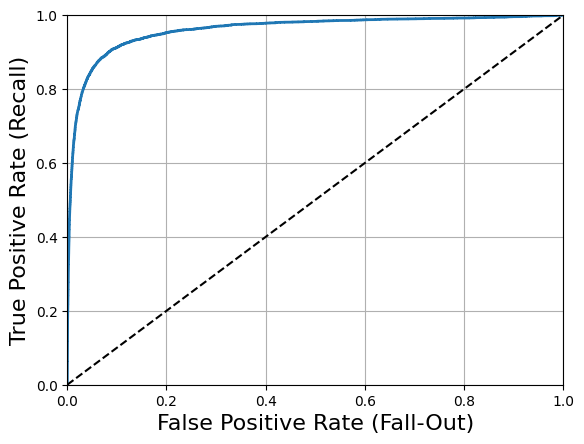

In [21]:
from sklearn.metrics import roc_curve

# compute the TPR and FPR for various threshold values
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# plot the FPR against the TPR


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)


plot_roc_curve(fpr, tpr)
plt.show()


In [22]:
from sklearn.metrics import roc_auc_score

# calculate the AUC
print(roc_auc_score(y_train_5, y_scores))


0.9604938554008616


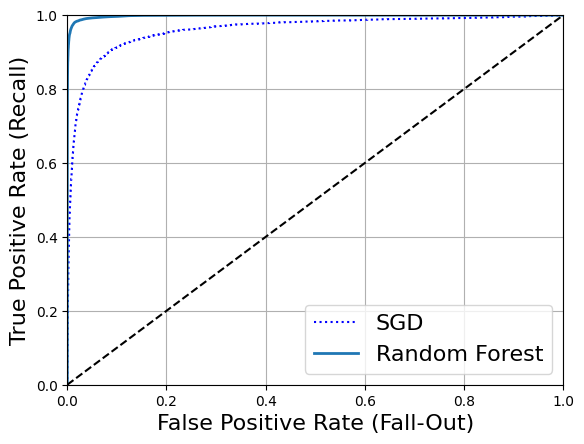

In [23]:
# train a RandomForestClassifier and compare it to the SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# get the scores of all instances in the training set
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# use the positive class's probability as the score
y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(
    y_train_5, y_scores_forest)

# plot both ROC curves on the same plot
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()


In [24]:
# calculate the AUC for the RandomForestClassifier
print(roc_auc_score(y_train_5, y_scores_forest))


0.9983436731328145


## <center> 4. Multiclass Classification </center>

In [25]:
# using a binary classifier to detect more than two classes
from sklearn.svm import SVC

# train a SVM classifier
svm_clf = SVC()
svm_clf.fit(X_train, y_train)  # y_train, not y_train_5
svm_clf.predict([some_digit])


array([5], dtype=uint8)

In [26]:
# view the decision function scores for each class
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)

# get the index of the highest score
print(np.argmax(some_digit_scores))

# get the classes
print(svm_clf.classes_)

# get the class with the highest score
print(svm_clf.classes_[5])


[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5
[0 1 2 3 4 5 6 7 8 9]
5


In [27]:
# use a OneVsRestClassifier to train a binary classifier
from sklearn.multiclass import OneVsRestClassifier

# train a SGDClassifier
ovr_clf = OneVsRestClassifier(SGDClassifier(random_state=42))
ovr_clf.fit(X_train, y_train)

# make a prediction
print(ovr_clf.predict([some_digit]))

# get the number of classifiers
print(len(ovr_clf.estimators_))


[5]
10


In [28]:
# train an SGDClassifier
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit]))

# get the decision function scores
print(sgd_clf.decision_function([some_digit]))

# use cross-validation to evaluate the SGDClassifier's accuracy
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")


[3]
[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]


array([0.87365, 0.85835, 0.8689 ])

In [29]:
# scale the inputs to improve the accuracy
from sklearn.preprocessing import StandardScaler

# create a StandardScaler
scaler = StandardScaler()

# scale the training set
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# use cross-validation to evaluate the SGDClassifier's accuracy
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.8983, 0.891 , 0.9018])

## <center> 5. Error Analysis </center>

In [30]:
# analyze the confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx


array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

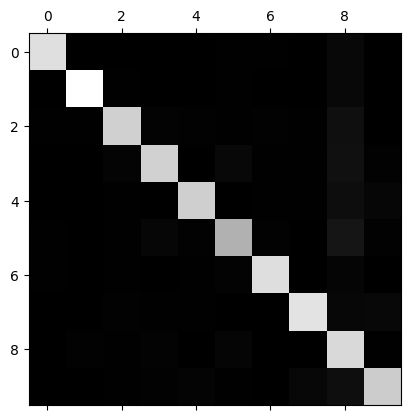

In [31]:
# visualize the confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()


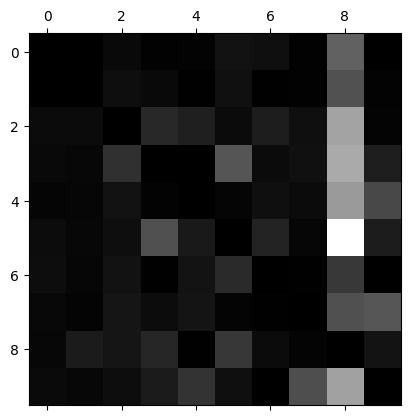

In [32]:
# focus the plot on the errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


<Axes: >

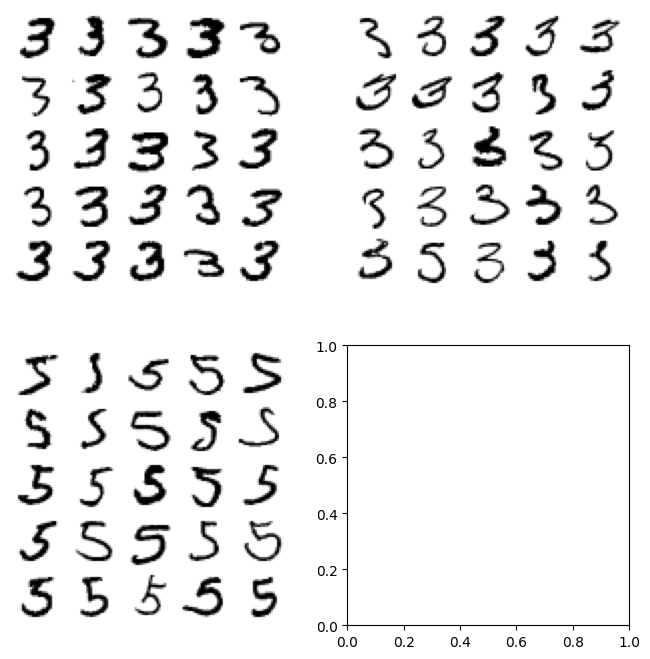

In [33]:
# create a function to plot images of digits
def plot_digits(instances, images_per_row=10, **options):
    # get the number of rows and columns
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]

    # create a new figure
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))

    # create the rows of images
    for row in range(n_rows):
        rimages = images[row * images_per_row: (row + 1) * images_per_row]

        # create a row of images
        row_images.append(np.concatenate(rimages, axis=1))

    # create the image
    image = np.concatenate(row_images, axis=0)

    # show the image
    plt.imshow(image, cmap=plt.cm.binary, **options)
    plt.axis("off")


# plot examples of 3s and 5s to analyze the errors
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# plot the examples
plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)


## <center> 6. Multilabel Classification </center>